In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import os.path

In [3]:
from settings import *
from utils import *

### Bar charts with the number of links per document.

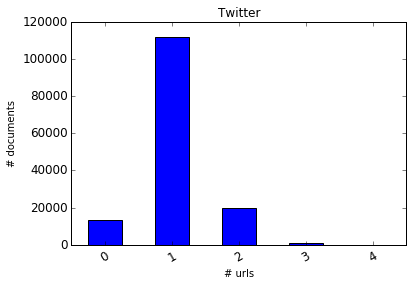

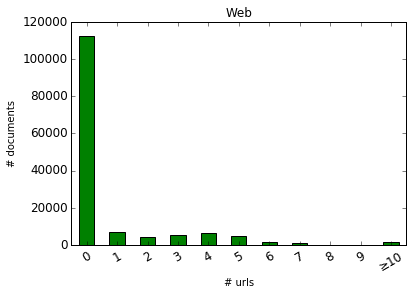

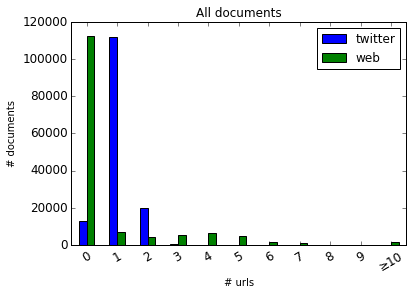

In [3]:
def plotCountLinks(limitDocuments=10):
    
    documents = readFromDB(limitDocuments)
    documents = extractLinks(documents)
    
    #Limit for the bar charts.
    urlLimit = 10
    
    #Writes the number of urls per document.
    #If the number is ≥ @urlLimit then instead
    #of the real number, we write "≥ @urlLimit".
    documents['urls'] = documents['urls'].apply(lambda x: len(x) if len(x)<urlLimit else "≥"+str(urlLimit))
    
    #Groups by the doc_type (twitter, web) and the number of urls.
    count =  documents.groupby(['doc_type','urls']).size()
    
    #Reformats the dataframe in order to create the plots.
    docs = {}
    for doc_type in count.index.levels[0]:
        urls=[]
        for urlNum in count.index.levels[1]:
            urls.append(count.get((doc_type, urlNum),0))
        docs[doc_type]=urls

    #Slices the dataframe into 3 views.
    bothCount=pd.DataFrame(docs, index=count.index.levels[1])
    twitterCount=bothCount['twitter'][lambda x: x!=0]
    webCount=bothCount['web'][lambda x: x!=0]
 
    #Creates the 3 plots.
    plt.xticks(rotation=70)
    ax = twitterCount.plot.bar(fontsize=12, color='b', title='Twitter')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel("# urls")
    ax.set_ylabel("# documents")
    plt.show()
    
    ax = webCount.plot.bar(fontsize=12, color='g', title='Web')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel("# urls")
    ax.set_ylabel("# documents")
    plt.show()
    
    ax = bothCount.plot.bar(fontsize=12, color='bg', title='All documents')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel("# urls")
    ax.set_ylabel("# documents")
    plt.show()

plotCountLinks(-1)

### Pie chars with the various URL errors.

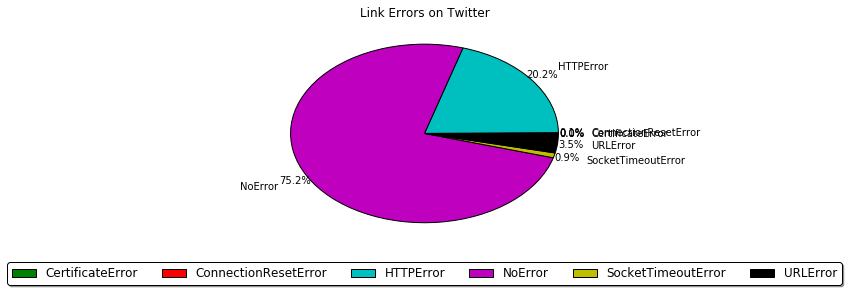

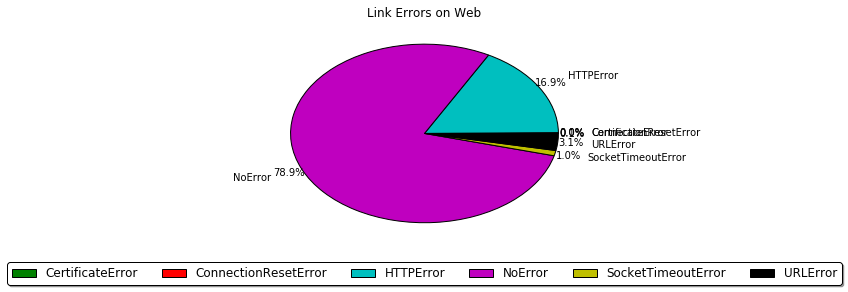

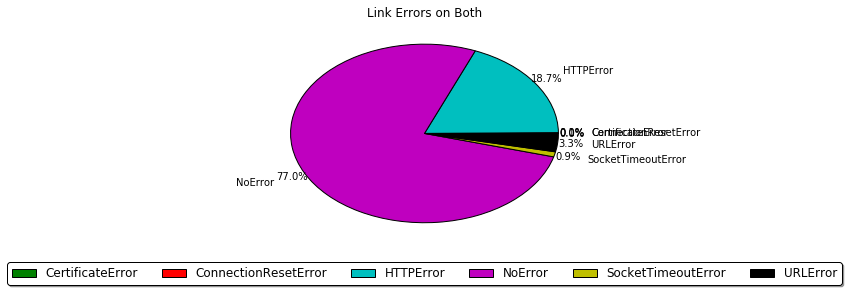

In [5]:
def plotLinkErrors(limitDocuments=10):
    
    if (os.path.exists(cachedDataFrame)):
        documents = pd.read_pickle(cachedDataFrame)
    else:
        documents = resolveURLs(limitDocuments)
        documents.to_pickle(cachedDataFrame)
    
    documents = documents[['doc_type','error']]
    
    #Groups and counts by error and plots the respective pies.
    twitter = documents[documents['doc_type']=='twitter']
    numOfLinks = twitter.shape[0]
    ax = twitter.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%1.1f%%', title='Link Errors on Twitter', pctdistance=1.1, labeldistance=1.25)
    ax.set_ylabel('')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=6)
    web = documents[documents['doc_type']=='web']
    numOfLinks = web.shape[0]
    ax = web.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%1.1f%%', title='Link Errors on Web', pctdistance=1.1, labeldistance=1.25)
    ax.set_ylabel('')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=6)
    numOfLinks = documents.shape[0]
    ax = documents.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%1.1f%%', title='Link Errors on Both', pctdistance=1.1, labeldistance=1.25)
    ax.set_ylabel('')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=6)

    
plotLinkErrors(-1)

### Sorts the domains of links by the number of occurrences.

In [5]:
def printDomains(limitDocuments=10):
    if (os.path.exists(cachedDataFrame)):
        documents = pd.read_pickle(cachedDataFrame)
    else:
        documents = resolveURLs(limitDocuments)
        documents.to_pickle(cachedDataFrame)

    documents = documents[documents['error']=='NoError']
    documents = documents[['id','resolvedURL','doc_type']]

    documents['resolvedURL'] = documents['resolvedURL'].apply(lambda x: urlparse(x).hostname)

    print('Twitter')
    print(documents[documents['doc_type']=='twitter'][['id','resolvedURL']].groupby('resolvedURL').agg('count').sort_values('id', ascending=False))
    print('Web')
    print(documents[documents['doc_type']=='web'][['id','resolvedURL']].groupby('resolvedURL').agg('count').sort_values('id', ascending=False))
    print('Both')
    print(documents[['id','resolvedURL']].groupby('resolvedURL').agg('count').sort_values('id', ascending=False))
printDomains(-1)

Twitter
                                       id
resolvedURL                              
twitter.com                         17897
time.com                             6394
www.forbes.com                       6042
www.seattleorganicrestaurants.com    5524
www.theguardian.com                  5131
seattleorganicrestaurants.com        2399
www.naturalnews.com                  2067
www.dailymail.co.uk                  2022
www.google.com                       1912
www.bloomberg.com                    1898
www.sciencedaily.com                 1726
edition.cnn.com                      1425
www.bbc.co.uk                        1083
www.facebook.com                     1023
mashable.com                         1017
www.cbc.ca                            984
www.independent.co.uk                 953
www.foxnews.com                       927
www.latimes.com                       833
www.npr.org                           786
abcnews.go.com                        732
www.medicalnewstoday.com  